<hr style="height:2px;border:none"/>
<img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">

<center>
    <h1> INF495 - Modelamiento Computacional Aplicado </h1>
    <h1> Project</h1>
    <h1> Modeling Fungi</h1>
    <h3>Jorge Sanhueza jorge.sanhuezac@sansano.usm.cl</h3>
</center>
<br>
<hr style="height:2px;border:none"/>

# Context

The project is based on the problem A of The Mathematical Contest in Modeling (MCM) 2021 
https://www.mathmodels.org/Problems/2021/MCM-A/2021_MCM_Problem_A.pdf>




The carbon cycle describes the process of the exchange of carbon throughout the geochemical
cycle of the Earth, and is a vital component for life on the planet.
Part of the carbon cycle includes the decomposition of compounds, allowing carbon to be renewed and used in other forms.
One key
component of this part of the process is the decomposition of plant material and woody fibers.

**Fungi** acts as a key agent in the decomposition of **wooden fibers and ground litter**

Different **fungi traits** affect in the **decomposition rate** of this fibers and ground litter.

For this MCM Problem you should focus on just two traits of a fungus:
 - The **growth rate** of the fungus
 - The fungus **tolerance to moisture**.
 
In particular, the slow growing strains of fungi tend to be better able to survive and grow in the presence of environmental changes with respect to moisture and temperature, while the faster growing strains tend to be less robust to the same changes.

The goal is to model the decomposition of woody fibers in a given patch of land, and do so in the presence of multiple types of fungi breaking down woody fibers in the same area.

As you explore the relationship of the two traits of interest, growth rate and moisture tolerance,
with the rate of decomposition, several questions may arise to include:

Using these two traits
- How do the different fungi **interact** and decompose ground litter in a fixed patch of land in different environments?
- Within these different environments, how will the **decomposition be impacted overtime** as conditions vary?
- How do environmental changes and the variation in environmental change impact the **long-term dynamics** with respect to decomposition, as well as competition between fungi in a given environment?

The estimation for the decomposition rates, given the growth rate, is shown
in Figure 1. The estimation of the decomposition rates, given the relative moisture tolerance, is
shown in Figure 2.


<img src="./figures/figures.png" style="width:70%">

# Agent-based Model 

# Enviroment

Patch of land of size nxm that holds Fungi and fibers. The humidity of the patch are separated by sections of different constant humidity.  

# Agents

Two types of fungi, slow growing strains of fungi (**S-Fungi**) and faster growing strains of fungi (**F-Fungi**).

Wood fibers and dead plant material (**Fibers**).

## S-Fungi
    - Decompose fibers slower
    - Withstands high humidity section
    - Grows slower than F-Fungi
    - When there is no fibers the fungi dies (lenght decreases?)
## F-Fungi
    - Decompose fibers faster
    - Cant Withstand high humidity section
    - Grows faster than S-Fungi
    - When there is no fibers the fungi dies (lenght decreases?)



In [22]:
import numpy as np
import matplotlib.pyplot as plt

np.random.choice(4)

1

In [23]:
np.random.rand(3,3)


array([[0.06307084, 0.75492266, 0.64573687],
       [0.54586404, 0.37443838, 0.38347439],
       [0.11255872, 0.16801213, 0.49301786]])

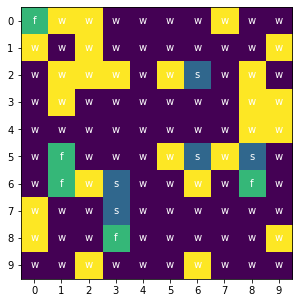

1000
[[2. 2. 3. 3. 3. 3. 3. 3. 3. 3.]
 [2. 3. 3. 3. 3. 3. 1. 3. 3. 3.]
 [3. 3. 3. 3. 3. 1. 1. 1. 3. 3.]
 [3. 3. 3. 3. 3. 3. 1. 3. 3. 3.]
 [3. 2. 3. 3. 3. 3. 1. 3. 1. 3.]
 [2. 2. 2. 1. 3. 1. 1. 1. 1. 1.]
 [2. 2. 2. 1. 1. 3. 1. 2. 2. 2.]
 [3. 2. 1. 1. 1. 3. 3. 3. 2. 3.]
 [3. 3. 2. 2. 2. 3. 3. 3. 3. 3.]
 [3. 3. 3. 2. 3. 3. 3. 3. 3. 3.]]


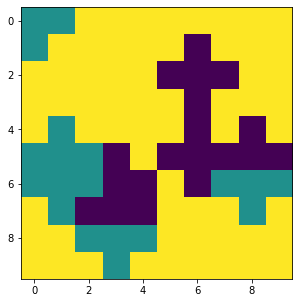

In [40]:
np.random.seed(31415)
class World:
    def __init__(self,n,m,n_sfungi,n_ffungi,prob_fiber,prob_sfungi,prob_ffungi):
        self.SLOWFUNGI=1
        self.FASTFUNGI=2
        self.WOODFIBER=3
        self.n = n
        self.m = m
        self.prob_fiber = prob_fiber
        self.prob_sfungi = prob_sfungi
        self.prob_ffungi = prob_ffungi

        self.land = np.zeros((n,n))

        
        self.populate_fibers = np.vectorize(self.scalar_populate_fibers)

        self.sfungis = []
        for sfungi in range(n_sfungi):
            x,y = (np.random.randint(n),np.random.randint(n))
            while self.land[x,y] != 0:
                x,y = (np.random.randint(n),np.random.randint(n))
            self.sfungis.append((x,y))
            self.land[x,y] = self.SLOWFUNGI


        self.ffungis = []
        for ffungi in range(n_ffungi):
            x,y = (np.random.randint(n),np.random.randint(n))
            while self.land[x,y] != 0:
                x,y = (np.random.randint(n),np.random.randint(n))
            self.ffungis.append((x,y))
            self.land[x,y] = self.FASTFUNGI

        self.fibers()
        self.humedad = np.random.rand(n,m)
        self.sun = 0




    def fibers(self):
        self.land = self.populate_fibers(self.land)
    def scalar_populate_fibers(self,x):
                if x==0 and np.random.choice([True,False],p=[self.prob_fiber,1-self.prob_fiber]) :
                    return self.WOODFIBER
                else:
                    return x
    def plot_world(self,annotate=False):
        fig, ax = plt.subplots(figsize=(5,5))
        ax.imshow(self.land,)#cmap="Greens")
        ax.set_xticks(range(self.m))
        ax.set_yticks(range(self.n))
        if annotate:
            for i in range(self.n):
                for j in range(self.m):
                    if self.land[i, j] == self.SLOWFUNGI:
                        text = ax.text(j, i, "s", ha="center", va="center", color="w")
                    elif self.land[i, j] == self.FASTFUNGI:
                        text = ax.text(j, i, "f", ha="center", va="center", color="w")
                    else:
                        text = ax.text(j, i, "w", ha="center", va="center", color="w")
        plt.show()

    def step_helper(self,pos):
        i,j = pos
        adjacent_indices = []
        if i > 0 and self.land[i-1,j]==3 :
            adjacent_indices.append((i-1,j))

        if i+1 < self.m and self.land[i+1,j]==3:
            adjacent_indices.append((i+1,j))

        if j > 0 and self.land[i,j-1]==3:
            adjacent_indices.append((i,j-1))

        if j+1 < self.n and self.land[i,j+1]==3:
            adjacent_indices.append((i,j+1))
        return adjacent_indices
    def step(self):
        for ffungi in self.ffungis:
            available = self.step_helper(ffungi)
            if available:
                x,y = available[ np.random.choice(len(available))]
                if np.random.rand()<self.prob_ffungi:
                    self.land[x,y] = self.FASTFUNGI

        for sfungi in self.sfungis:
            available = self.step_helper(sfungi)
            if available:
                x,y = available[ np.random.choice(len(available))]
                if np.random.rand()<self.prob_sfungi:
                    self.land[x,y] = self.SLOWFUNGI


world = World(n=10,m=10,n_sfungi=5,n_ffungi=5,prob_fiber=.3,prob_sfungi=0.3,prob_ffungi=0.4)
t=0
timelimit = 1000
world.plot_world(True)
while(t<timelimit):
    #print(t)
    #print(world.land)
    #world.plot_world(True)
    world.step()
    world.fibers()
    t+=1
print(t)
print(world.land)
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(world.land)

